In [2]:
!pip install torchsummary


Defaulting to user installation because normal site-packages is not writeable


# Importing all the necessary modules

In [1]:
import torchvision
import torch.utils.data as data
import torchvision.transforms as transforms
import torch
import numpy as np
import copy
from torchsummary import summary
from torch.optim import lr_scheduler
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import time
import matplotlib.pyplot as plt
import pandas as pd

# Using SEED to generate random number

SEED = 1234

np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Loading CIFAR-10 Dataset

In [2]:
# Train transformations
# Image Normalization means based on CIFAR-10 Images

train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# Test transformations

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

In [3]:
# Training and Validation Loader
training_dataset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=train_transform)

# Validation Data ratio from Training data
valid_ratio = 0.8

# Number of training samples
num_training = int(len(training_dataset) * valid_ratio)

# Number of test samples
num_validations = len(training_dataset) - num_training

# Dividing train and validation based on number of samples
training_data, validation_data = data.random_split(training_dataset, 
                                           [num_training, num_validations])

# Train Data Loader
trainloader = torch.utils.data.DataLoader(
    training_data, batch_size = 32, shuffle = True, num_workers = 2)

# Applying test transform on validation data after a deepcopy
validation_data = copy.deepcopy(validation_data)
validation_data.dataset.transform = test_transform

# Validation Data Loader
validloader = torch.utils.data.DataLoader(
    validation_data, batch_size=128, shuffle=False, num_workers=2)

#Test Loader
test_dataset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=test_transform)
testloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=100, shuffle=False, num_workers=2)


#Datalaoders
dataloaders = {'train': trainloader,  'valid': validloader, 'test': testloader}
dataset_sizes = {'train': len(trainloader.dataset), 'valid': len(validloader.dataset), 'test': len(testloader.dataset)}

Files already downloaded and verified
Files already downloaded and verified


In [4]:
# CIFAR-10 dataset comprising class labels
classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

In [5]:
# Defining the Basic module
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=True)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=True)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=True),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

# Defining the Bottleneck module
class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size = 1, bias = True)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size = 3,
                               stride = stride, padding = 1, bias = True)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion *
                               planes, kernel_size = 1, bias = True)
        self.bn3 = nn.BatchNorm2d(self.expansion * planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion * planes,
                          kernel_size = 1, stride = stride, bias = True),
                nn.BatchNorm2d(self.expansion * planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

# Defining the modified ResNet module for skip connections
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10, dropout=0.6):
        super(ResNet, self).__init__()
        self.in_planes = 64
        
        # Conv layer with size 64, channel 3, kernel size 3, stride 1, padding 1
        self.conv1 = nn.Conv2d(3, 64, kernel_size = 3,
                               stride = 1, padding = 1, bias = True)
        # Applying batch normalization
        self.bn1 = nn.BatchNorm2d(64)
        # Using make_layer function to build size 64 blocks with stride 1
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride = 1)
        # Using make_layer function to build size 128 blocks with stride 2
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride = 2)
        # Using make_layer function to build size 256 blocks with stride 2
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride = 2)
        # Using make_layer function to build size 512 blocks with stride 2
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride = 2)
        # Adding dropout 
        self.dropout = nn.Dropout(dropout)
        # Linear fully connected layer 
        self.linear = nn.Linear(512 * block.expansion, num_classes)

    # Defining function to make convolution layer using different parameters
    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)
    
    # Feed Forward function with layout
    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.dropout(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

In [6]:
# Defining the layer configuration
config = [2, 1, 1, 1]

# Making model 
model = ResNet(BasicBlock, config)

# Printing total training parameters
print("Number of trainable parameters:", sum(p.numel() for p in model.parameters()))

Number of trainable parameters: 4980234


In [7]:
# Function to initialize parameters
def initialize_parameters(m):
    if isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight.data, nonlinearity = 'relu')
        nn.init.constant_(m.bias.data, 0)
    elif isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight.data, gain = nn.init.calculate_gain('relu'))
        nn.init.constant_(m.bias.data, 0)

# Applying initialized parameters to the model        
model.apply(initialize_parameters)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential

In [8]:
# Selecting CPU or CUDA
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = model.to(device)

# Criterion used for the model
criterion = nn.CrossEntropyLoss(reduction='sum')

# Number of Epochs
EPOCH = 300

# Learning rate
lr = 0.001

# Weight decay
weightDecay = 0.0001

# Different types of optimizer
# optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weightDecay)
# optimizer = optim.RMSprop(model.parameters(), lr=0.001, momentum=0.9, weight_decay=5e-4)
# optimizer = optim.Adadelta(model.parameters(), lr=lr, weight_decay=weightDecay)
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=weightDecay)

# Different types of scheduler
# scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.5)
# scheduler = lr_scheduler.ExponentialLR(optimizer, gamma = 0.9)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor = 0.5, patience=5, cooldown=2)
# scheduler = lr_scheduler.CosineAnnealingLR(optimizer, eta_min = lr/50.0, T_max=100)

# Training the model

In [9]:
# Defining function to train the model
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    start = time.time()

    best_accuracy = 0.0
    training_loss = []
    validation_loss = []
    training_accuracy = []
    validation_accuracy = []
    
    # Iterating over total number of epochs
    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode
                
            
            # Initializing statistics 
            running_loss = 0.0
            running_corrects = 0

            # Iterate over data
            for inputs, labels in dataloaders[phase]:
                # Transferring inputs and labels CPU to GPU for training
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Track history if current phase is in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backward + Optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
            if phase == 'train':
                scheduler.step(running_loss)
            
            # Calculation per epoch loss and accuracy
            loss_per_epoch = running_loss / dataset_sizes[phase]
            accuracy_per_epoch = running_corrects.double() / dataset_sizes[phase]
            
            if phase == 'valid':
                validation_loss.append(loss_per_epoch)
                validation_accuracy.append(accuracy_per_epoch)
            else:
                training_loss.append(loss_per_epoch)
                training_accuracy.append(accuracy_per_epoch)
            
            print(f'{phase} Loss: {loss_per_epoch:.4f} Accuracy: {accuracy_per_epoch:.4f}')

            # Deep copy the model
            if phase == 'valid' and accuracy_per_epoch > best_accuracy:
                best_accuracy = accuracy_per_epoch
                best_model_wts = copy.deepcopy(model.state_dict())   

    time_elapsed = time.time() - start
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Accuracy: {best_accuracy:4f}')


    # Load the best model weights
    model.load_state_dict(best_model_wts)
    return model, training_loss, validation_loss, training_accuracy, validation_accuracy

In [10]:
model, training_loss, validation_loss, training_accuracy, validation_accuracy = train_model(model, criterion, optimizer, scheduler, EPOCH)


Epoch 0/299
----------
train Loss: 52.8541 Accuracy: 0.4030
valid Loss: 183.6120 Accuracy: 0.5041
Epoch 1/299
----------
train Loss: 37.4380 Accuracy: 0.5797
valid Loss: 130.5907 Accuracy: 0.6412
Epoch 2/299
----------
train Loss: 30.5972 Accuracy: 0.6603
valid Loss: 108.8548 Accuracy: 0.7055
Epoch 3/299
----------
train Loss: 26.0691 Accuracy: 0.7144
valid Loss: 96.6784 Accuracy: 0.7528
Epoch 4/299
----------
train Loss: 22.7926 Accuracy: 0.7490
valid Loss: 88.7677 Accuracy: 0.7729
Epoch 5/299
----------
train Loss: 20.4521 Accuracy: 0.7763
valid Loss: 76.8354 Accuracy: 0.7998
Epoch 6/299
----------
train Loss: 18.6067 Accuracy: 0.7977
valid Loss: 72.2227 Accuracy: 0.8099
Epoch 7/299
----------
train Loss: 17.2352 Accuracy: 0.8121
valid Loss: 66.8764 Accuracy: 0.8251
Epoch 8/299
----------
train Loss: 15.9832 Accuracy: 0.8251
valid Loss: 66.2056 Accuracy: 0.8298
Epoch 9/299
----------
train Loss: 14.8341 Accuracy: 0.8401
valid Loss: 63.8814 Accuracy: 0.8382
Epoch 10/299
----------
tra

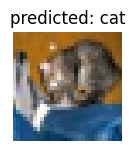

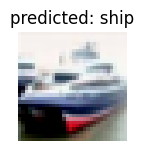

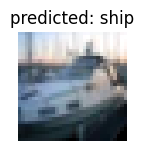

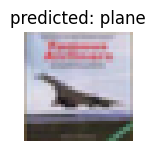

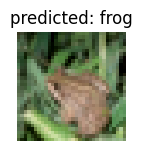

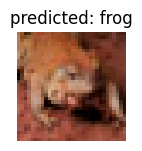

In [11]:
# Image show for Tensor
def imshow(inp, title = None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

# Visualizing the images with its respective label
def visualize_model(model, num_images = 6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {classes[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)
        
visualize_model(model)

# Testing the model

In [13]:
def test_model(model):
    
    was_training = model.training
    model.eval()
    all_labels = []
    all_preds = []


    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_labels.append(labels)
            all_preds.append(preds)
            
    model.train(mode=was_training)
    return all_labels, all_preds
    
labels, preds = test_model(model)

In [ ]:
# Actual labels & Predictive labels
labels = [j  for i in labels for j in i.cpu().tolist()[:]]
preds = [j  for i in preds for j in i.cpu().tolist()[:]]

# Performance Metrics

In [85]:
# Printing overall metrics
print("Overall metrics")
print("Accuracy:", accuracy_score(labels, preds))
print("Recall:", recall_score(labels, preds, average='weighted'))
print("Precision:", precision_score(labels, preds, average='weighted'))
print("F1:", f1_score(labels, preds, average='weighted'))

Overall metrics
Accuracy: 0.9266
Recall: 0.9266
Precision: 0.92650090841321
F1: 0.9265005358781738


In [87]:
# Printing indiviual metrics, recall, precision and f1 scores for each classes separately
recall_scores = recall_score(labels, preds, average=None)
precision_scores = precision_score(labels, preds, average=None)
f1_scores = f1_score(labels, preds, average=None)
scores = pd.DataFrame({'Class': classes, 'Recall': recall_scores, 'Precision':precision_scores,'F1':f1_scores})
print(scores)

   Class  Recall  Precision        F1
0  plane   0.934   0.926587  0.930279
1    car   0.971   0.960435  0.965689
2   bird   0.900   0.910010  0.904977
3    cat   0.838   0.863028  0.850330
4   deer   0.927   0.917822  0.922388
5    dog   0.899   0.881373  0.890099
6   frog   0.942   0.952477  0.947210
7  horse   0.945   0.947844  0.946420
8   ship   0.962   0.945919  0.953892
9  truck   0.948   0.959514  0.953722


# Inference

In [101]:
# Plotting the accuracy for Training and Validation
def plot_accuracies(training_accuracy, validation_accuracy):
    plt.figure(figsize = (5, 5))
    plt.plot(training_accuracy, '-x')
    plt.plot(validation_accuracy, '-x')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Accuracy vs. Epochs');

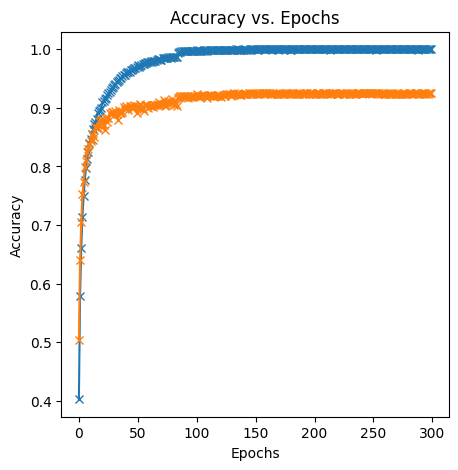

In [102]:
plot_accuracies([i.cpu() for i in training_accuracy], [i.cpu() for i in validation_accuracy])

In [103]:
# Plotting the Loss for Training and Validation
def plot_losses(training_loss, validation_loss):
    plt.figure(figsize = (5, 5))
    plt.plot(training_loss, '-x')
    plt.plot(validation_loss, '-x')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. Epochs');

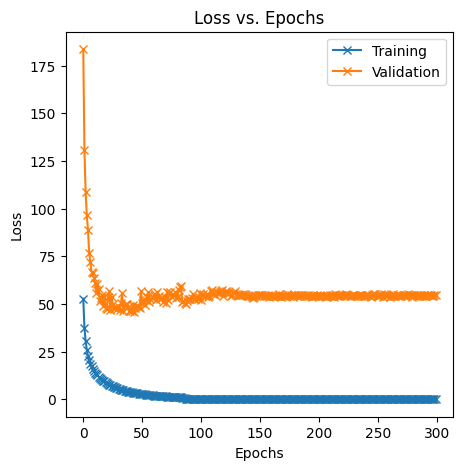

In [104]:
plot_losses(training_loss, validation_loss )

# References

1) https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html
2) https://github.com/kuangliu/pytorch-cifar
3) He, K.; Zhang, X.; Ren, S.; and Sun, J. 2016. Deep Residual Learning for Image Recognition. In Proceedings of 2016IEEE  Conference on Computer Vision and Pattern Recognition, CVPR ’16, 770–778. IEEE.